In [1]:
import os
import sys
import random
import warnings
import math
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import metrics

import tensorflow as tf
import cv2 as cv
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../kaggle/stage1_train/'
TEST_PATH = '../kaggle/stage2_test_final/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

C:\Users\Sid\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
train_ids = train_ids[::500]
test_ids = test_ids[2600:]

In [3]:
len(test_ids)

419

In [4]:
def img_chop(im):
    x, y, z = im.shape
   
    out = np.empty((0,IMG_HEIGHT, IMG_WIDTH, z))
    
    img_x_start = 0
    img_x_end = 0
    img_y_start = 0
    img_y_end = 0
    
    x_muls = math.ceil(x/IMG_HEIGHT)
    y_muls = math.ceil(y/IMG_HEIGHT)
 
    for i in range(0,x_muls):
        img_x_start = i*IMG_WIDTH
        img_x_end = IMG_WIDTH*(i + 1)
        
        if img_x_end > x:
            img_x_start = -1*IMG_WIDTH
            img_x_end = x
                    
        for j in range(0,y_muls):
            img_y_start = j*IMG_HEIGHT
            img_y_end = IMG_HEIGHT*(j+1)
            
            if img_y_end > y:
                img_y_start = -1*IMG_HEIGHT
                img_y_end = y
            
            img_sliced = im[img_x_start:img_x_end,img_y_start:img_y_end,:]
            temp = np.expand_dims(img_sliced,axis=0)
            
            out = np.concatenate((out,temp),axis=0)
            
    
    return out

def process_img(im):
    cim = cv.cvtColor(im,cv.COLOR_BGR2Luv)
    gray = cim[:,:,0]
    print("gray image")
    imshow(gray)
    plt.show()

    thresh = cv.threshold(gray, 0, 255,cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    
    print("threshold image")
    imshow(gray)
    plt.show()

    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)

    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    return labels




In [5]:
Y_train = np.empty((0, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
X_train = np.empty((0,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train_size = []
for n, id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    
    path = TRAIN_PATH + id_
   
   
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
   
    
    X_train_size.insert(n,img.shape)
    out = img_chop(img)
    X_train = np.concatenate((X_train,out),axis=0)
    
    mask = np.zeros((img.shape[0],img.shape[1], 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    
    temp = img_chop(mask)
   
    Y_train = np.concatenate((Y_train,temp),axis=0)
   # print(Y_train.shape,temp.shape,mask.shape)
    
   
X_test = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and chopping test data ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img =  imread(path + '/images/' + id_ + '.png')
    if len(img.shape)==3:
        img = img[:,:,:IMG_CHANNELS]
    else:
        img = np.resize(img,(img.shape[0],img.shape[1],IMG_CHANNELS))
    sizes_test.append([img.shape[0], img.shape[1]])
    temp = img_chop(img)
    X_test = np.concatenate((X_test,temp),axis=0)

print('Done!')  

    
print(X_train.shape,Y_train.shape, X_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


Getting and chopping test data 


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [08:05<00:00,  1.16s/it]


Done!
(13, 128, 128, 3) (13, 128, 128, 1) (5957, 128, 128, 3)


In [6]:
Y_train = np.divide(Y_train,255)

In [18]:
img = imread('../lena.png')[:,:,1]
print(img.shape)                           
img = np.resize(img,(img.shape[0],img.shape[1],IMG_CHANNELS))
img.shape
img.max()


(300, 300)


242

C:\Users\Sid\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


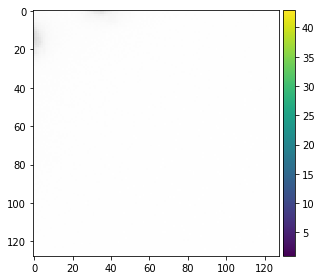

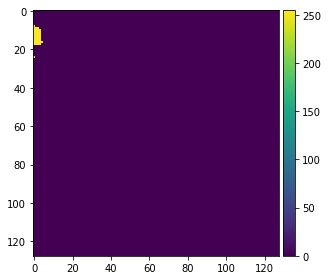

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
       
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 1)  17          conv2d_18[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [10]:
# Fit model

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-3.h5', verbose=1, save_best_only=True)
Y_train.max()

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Train on 11 samples, validate on 2 samples
Epoch 1/50


InvalidArgumentError: assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (metrics/mean_iou/mean_iou_8/confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (metrics/mean_iou/mean_iou_8/ToInt64_2:0) = ] [2]
	 [[Node: metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert = Assert[T=[DT_STRING, DT_STRING, DT_STRING, DT_INT64, DT_STRING, DT_INT64], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_0, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_1, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_2, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch_1, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_4, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch_2)]]

Caused by op 'metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert', defined at:
  File "C:\Users\Sid\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sid\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Sid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-911bb200aaa2>", line 56, in <module>
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
  File "C:\Users\Sid\Anaconda3\lib\site-packages\keras\engine\training.py", line 934, in compile
    handle_metrics(output_metrics)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\keras\engine\training.py", line 913, in handle_metrics
    mask=masks[i])
  File "C:\Users\Sid\Anaconda3\lib\site-packages\keras\engine\training.py", line 429, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-8-675ffec2c83e>", line 7, in mean_iou
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\metrics_impl.py", line 1009, in mean_iou
    num_classes, weights)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\metrics_impl.py", line 263, in _streaming_confusion_matrix
    labels, predictions, num_classes, weights=weights, dtype=dtypes.float64)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\confusion_matrix.py", line 176, in confusion_matrix
    labels, num_classes_int64, message='`labels` out of bound')],
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\check_ops.py", line 579, in assert_less
    return control_flow_ops.Assert(condition, data, summarize=summarize)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 180, in Assert
    guarded_assert = cond(condition, no_op, true_assert, name="AssertGuard")
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2056, in cond
    orig_res_f, res_f = context_f.BuildCondBranch(false_fn)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1897, in BuildCondBranch
    original_result = fn()
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 178, in true_assert
    condition, data, summarize, name="Assert")
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 51, in _assert
    name=name)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "C:\Users\Sid\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (metrics/mean_iou/mean_iou_8/confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (metrics/mean_iou/mean_iou_8/ToInt64_2:0) = ] [2]
	 [[Node: metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert = Assert[T=[DT_STRING, DT_STRING, DT_STRING, DT_INT64, DT_STRING, DT_INT64], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_0, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_1, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_2, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch_1, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/data_4, metrics/mean_iou/mean_iou_8/confusion_matrix/assert_less/Assert/AssertGuard/Assert/Switch_2)]]


All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [8]:


# Predict on train, val and test
model = load_model('model-dsbowl2018-3.h5', custom_objects={'mean_iou': mean_iou})
print("model loaded")
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
print("predication_train")
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
print("prediction_val")
preds_test = model.predict(X_test, verbose=1)
print("prediction_test")
# Threshold predictions



model loaded
11/11 [==============================] - 2s 158ms/step
predication_train
2/2 [==============================] - 0s 144ms/step
prediction_val
5957/5957 [==============================] - ETA: 14:0 - ETA: 13:2 - ETA: 12:2 - ETA: 11:5 - ETA: 11:2 - ETA: 11:1 - ETA: 11:0 - ETA: 10:5 - ETA: 10:4 - ETA: 10:3 - ETA: 10:2 - ETA: 10:2 - ETA: 10:1 - ETA: 10:1 - ETA: 10:0 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: 

In [9]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



C:\Users\Sid\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


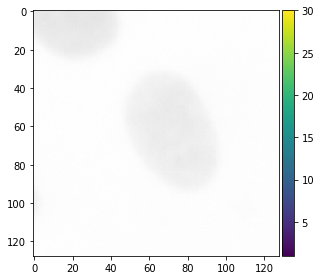

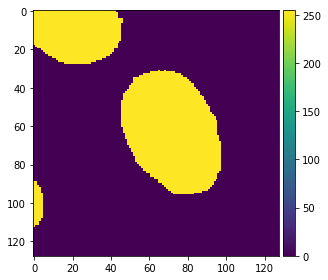

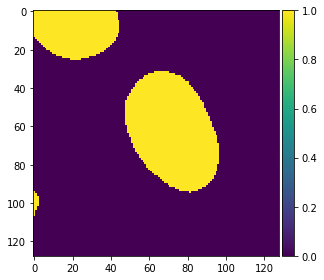

In [10]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

C:\Users\Sid\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


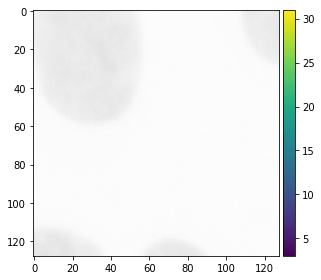

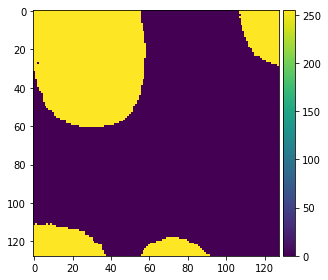

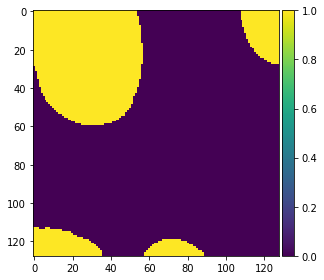

In [11]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [12]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [13]:
def img_assemble(im,size_im):
    x = math.ceil(size_im[0]/IMG_WIDTH)
    y = math.ceil(size_im[1]/IMG_HEIGHT)
    out = np.zeros(size_im)
    out= np.expand_dims(out,-1)
    idx = 0
    
    for i in range(0,x):
        out_x_start = i*IMG_WIDTH
        out_x_end = IMG_WIDTH*(i + 1)
        
        im_x_start = 0
        im_x_end = IMG_WIDTH
        
        if out_x_end > size_im[0]:
            out_x_start = IMG_HEIGHT*(i)
            out_x_end = size_im[0]
            im_x_start = IMG_WIDTH*i - size_im[0]
            
       
        for j in range(0,y):
            
            out_y_start = j*IMG_HEIGHT
            out_y_end = IMG_HEIGHT*(j+1)
            
            im_y_start = 0
            im_y_end = IMG_HEIGHT
            
            if out_y_end > size_im[1]:
                out_y_start = IMG_HEIGHT*(j)
                out_y_end =  size_im[1] 
                im_y_start =  IMG_HEIGHT*(j) - size_im[1]
             
            #print(im_x_start,im_x_end,im_y_start,im_y_end)
            #print(out_x_start,out_x_end,out_y_start,out_y_end)
            out[out_x_start:out_x_end,out_y_start:out_y_end,:] = im[idx][im_x_start:im_x_end,im_y_start:im_y_end,:]
            idx = idx+1
      
         #   imshow(out)
         #   plt.show()
    return out

In [14]:
new_test_ids = []
rles = []
end_num = 0
start_num = 0
print(preds_test.shape)
for n, id_ in tqdm(enumerate(test_ids),total= len(test_ids)):
  
    end_num = end_num + math.ceil(sizes_test[n][0]/IMG_WIDTH)*math.ceil(sizes_test[n][1]/IMG_HEIGHT)
    a_im = img_assemble(preds_test[start_num:end_num,:,:,:],sizes_test[n]) 
    rle = list(prob_to_rles(a_im))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    start_num = end_num

(5957, 128, 128, 1)


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:38<00:00,  4.27it/s]


... and then finally create our submission!

In [15]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('s2600-3019.csv', index=False)
print("done")


done


This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB